# Case study 3: Flinders ranges

In [1]:
import folium
from ipyleaflet import Map, basemaps, GeoJSON, LayersControl, DrawControl,WMSLayer, GeoData
from ipywidgets import Label
from ipywidgets import Label
import ipywidgets as widgets
import numpy as np
from shapely.geometry import Polygon
import geopandas
import pandas as pd
import lavavu

In [2]:
map_crs = 'EPSG:4326'
proj_crs = 'EPSG:28354'

Here we define a bounding box for the model, it will be displayed on a map in the next cell. You can use the map to draw your own bounding box if you want to try different model areas. 

**Warning** if you try new areas it may not work as expected because the modelling process assumes chronostratigraphic stratigraphy and requires adequate structural data. The structural data are shown by the red dots. 

In [5]:
existing_extent = (138.362206, -32.463842, 139.262268, -31.999178)
center = (existing_extent[1]+existing_extent[3])/2, (existing_extent[0]+existing_extent[2])/2
minlat = existing_extent[3]
maxlat = existing_extent[1]
minlong = existing_extent[2]
maxlong = existing_extent[0]
lat_point_list = [minlat, minlat, maxlat, maxlat,maxlat]
lon_point_list = [minlong, maxlong, maxlong, minlong, minlong]
bbox_geom = Polygon(zip(lon_point_list, lat_point_list))
mbbox = geopandas.GeoDataFrame(index=[0], crs=map_crs, geometry=[bbox_geom])
example_rect = GeoData(geo_dataframe = mbbox,
                   style={'color': 'purple', 'opacity':3, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},                  
                   name = 'Example')
print(map_crs,mbbox.total_bounds)
mbbox=mbbox.to_crs(proj_crs)
print(proj_crs,mbbox.total_bounds)


EPSG:4326 [138.362206 -32.463842 139.262268 -31.999178]
EPSG:28354 [ 250805.15298565 6405084.32805869  336682.92153939 6458336.08597563]


In [6]:
# center=(-33.5,138.7)

wms_warox = WMSLayer(
    url='http://geo.loop-gis.org/geoserver/GSSA/wms?',
    layers='GSSA:sth_flinders',
    format='image/png',
    transparent=True,
    attribution='Outcrop data from GSSA',
    name='outcrops'

)
wms_geol = WMSLayer(
    url='http://geo.loop-gis.org/geoserver/GSSA/wms?',
    layers='GSSA:2m surface geology',
    format='image/png',
    transparent=True,
    opacity=0.4,
    attribution='Geology data from GSSA',
    name='geology'

)
m =Map(basemap=basemaps.OpenTopoMap, center=center, zoom=8,scroll_wheel_zoom=True)
label = Label()
display(label)

def handle_interaction(**kwargs):
    if kwargs.get('type') == 'mousemove':
        label.value = str(kwargs.get('coordinates'))

m.on_interaction(handle_interaction)
m.add_layer(wms_geol)
m.add_layer(wms_warox)
# if(not test_data_name =='Draw Your Own'):
#     m.add_layer(example_rect)


m.add_control(LayersControl())
dc = DrawControl(rectangle={'shapeOptions': {'color': '#0000FF'}})
m.add_control(dc)
m.add_layer(example_rect)
m

Label(value='')

Map(center=[-32.23151, 138.81223699999998], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_i…

In [7]:
from geopandas import GeoDataFrame
from shapely.geometry import shape 
draw = dc.last_draw
try:
    poly = shape(draw['geometry'])
    poly_gdf = GeoDataFrame([1], geometry=[poly], crs=map_crs)
    bbox_gdf = poly_gdf.to_crs(proj_crs)
    bbox_3d = {"minx": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "miny": np.min(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "maxx": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[0]),
         "maxy": np.max(bbox_gdf.loc[:,'geometry'][0].exterior.xy[1]),
         "base": -3200,
         "top": 1200,}
except:
    minx = mbbox.total_bounds[0]
    maxx = mbbox.total_bounds[2]
    miny = mbbox.total_bounds[1]
    maxy = mbbox.total_bounds[3]# [ 274934.13200956 6297758.41393543  323980.90024616 6329307.64682912]
    bbox_3d = {'minx': minx,
     'miny': miny,
     'maxx': maxx,
     'maxy': maxy,
     'base': -3200,
     'top': 1200}

## Map2Loop
This process uses map2loop to process the goelogical datasets. Here we use local files.


 orientations layer  metadata
--------------------
    bbox [ 251265.92339537 6405219.91312584  336426.97143085 6458322.32358355]
    CRS epsg:28354
    # items 380
    Data types ['Point']

 geology layer  metadata
--------------------
    bbox [ 218644.77872317 6354880.91322556  406152.30668822 6482266.47242361]
    CRS epsg:28354
    # items 84
    Data types ['Polygon']

 fold layer  metadata
--------------------
    empty file, check contents

 fault layer  metadata
--------------------
    bbox [ 251200.08969364 6405084.32805869  300888.60554507 6458336.08597563]
    CRS +init=epsg:28354 +type=crs
    # items 16
    Data types ['LineString']

 mindeps layer  metadata
--------------------
    empty file, check contents

Warnings:
     No extra litho for geology polygons
     No more extra litho for geology polygons
     84 NaN/blank found in column "STRATDESC" of geology file, replacing with 0
     No fold polarity for fold polylines
     No fault dip for fault polylines
     No 

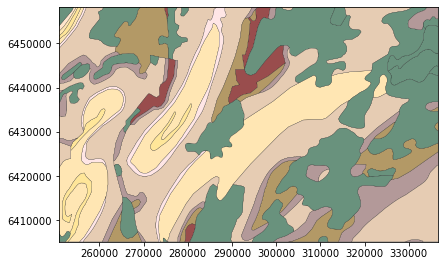

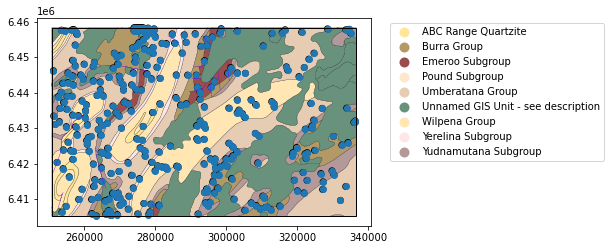

In [6]:
import os
import hjson
import map2loop
map2loop._clut_path='SA/data/GSSA_2M_colours.csv'
from map2loop.project import Project
proj = Project( 
                 structure_file='SA/data/sth_flinders_28354.shp',
                fault_file='SA/data/2M Linear Structures_28354.shp',
                fold_file='SA/data/2M Linear Structures_28354.shp',
                geology_file='SA/data/2M_Surface_Geology_28354_relage.shp',
                mindep_file="SA/data/null_mindeps.shp",
                 metadata='SA/data/meta.hjson',
#                  state = "SA",
#                  remote = False,
#                 clut_path='SA/data/GSSA_2M_colours.csv'
                 # path to hosted metadata describing the remote sources
#                  metadata='https://gist.githubusercontent.com/yohanderose/8f843de0dde531f009a3973cbdadcc9f/raw/918f412ae488ce1a6bca188306f7730061ecf551/meta_remote.hjson')                
)
proj.update_config(
                    out_dir='sa-test',
                    bbox_3d=bbox_3d,
                    proj_crs={'init': 'EPSG:28354'},
#                     quiet=True,
#                     overwrite="true",
                    drift_prefix=['T','Q','water','void']
                  )

  0%|          | 0/100 [00:00<?, ?it/s]

Generating topology analyser input...
84  polygons
Successful parameter load
Output directory created at: sa-test/graph
Topology analysis complete.

Resolving ambiguities using ASUD...	output_dir:Done.
Generating topology graph display and unit groups...
0    'Heysen Supergroup', 'anchor': 'n', 'fontStyle': 'bold'
1    'Unnamed GIS Unit - see description', 'anchor': 'n', 'fontStyle': 'bold'
2    'Warrina Supergroup', 'anchor': 'n', 'fontStyle': 'bold'
3    'Wilpena Group', 'anchor': 'n', 'fontStyle': 'bold'
4    'ABC Range Quartzite'
5    'Burra Group'
6    'Emeroo Subgroup'
7    'Pound Subgroup'
8    'Umberatana Group'
9    'Unnamed GIS Unit - see description'
10    'Wilpena Group'
11    'Yerelina Subgroup'
12    'Yudnamutana Subgroup'
Topology figure saved to sa-test/tmp/topology-fig.png


 10%|█         | 10/100 [00:01<00:15,  5.72it/s]

Done
Fetching DTM...  bbox:138.2487471414877 139.37108898881752 -32.579487181629595 -31.883661960489242
Attempt: 0 dtm geotif saved as sa-test/dtm/dtm.tif
Done.
reprojected dtm geotif saved as sa-test/dtm/dtm_rp.tif


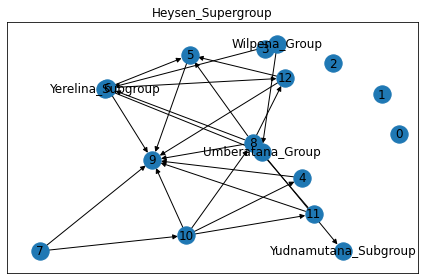

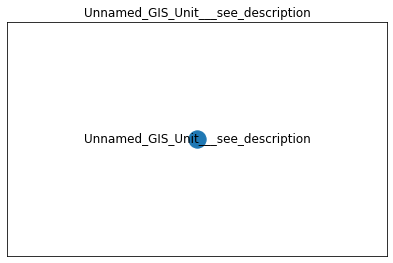

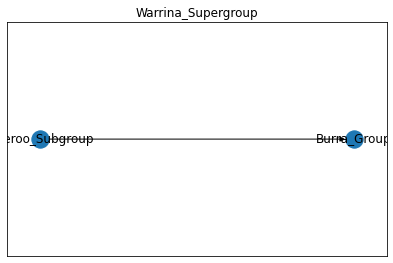

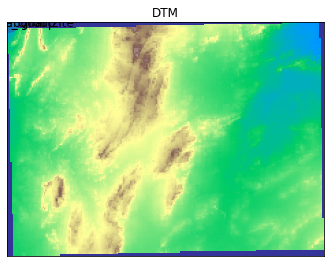

 30%|███       | 30/100 [00:04<00:09,  7.47it/s]

group choices: 1
dtb and dtb_null set to 0
380 orientations saved to sa-test/output/orientations.csv


 50%|█████     | 50/100 [00:05<00:04, 11.35it/s]

extra orientations saved as /empty_series_orientations.csv
basal contacts saved allpts =  2786 deci_pts =  892
saved as sa-test/tmp/all_contacts.csv and sa-test/tmp/contacts.csv
basal contacts without faults saved as sa-test/tmp/basal_contacts.shp
decimated contacts saved as sa-test/output/contacts4.csv


 60%|██████    | 60/100 [00:11<00:09,  4.04it/s]

All observations n= 380
groups ['Warrina Supergroup' 'Heysen Supergroup'
 'Unnamed GIS Unit - see description' 'Wilpena Group'
 'Moralana Supergroup'] 
codes ['Emeroo Subgroup' 'Yudnamutana Subgroup'
 'Unnamed GIS Unit - see description' 'ABC Range Quartzite'
 'Pound Subgroup' 'Wilpena Group' 'Umberatana Group' 'Yerelina Subgroup'
 'Burra Group']


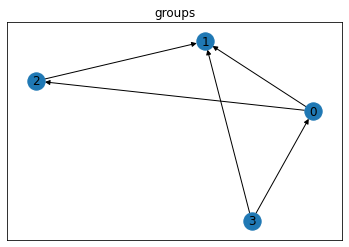

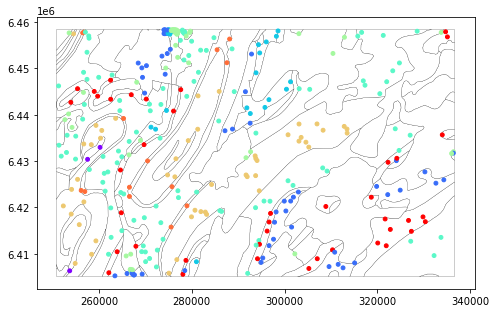

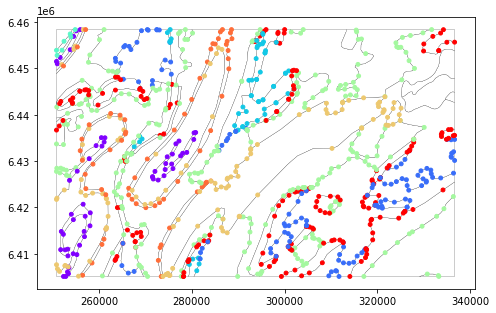

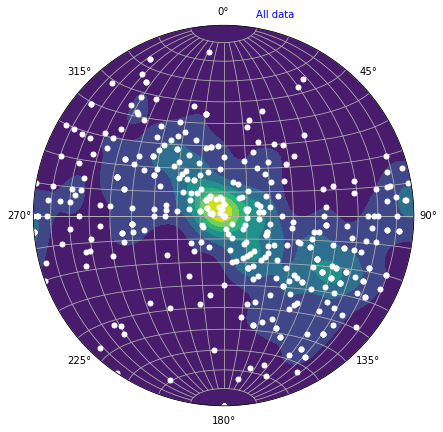

----------------------------------------------------------------------------------------------------------------------
Warrina Supergroup observations n= 102
strike/dip of girdle 269.72659235794464 / 89.24932719291581


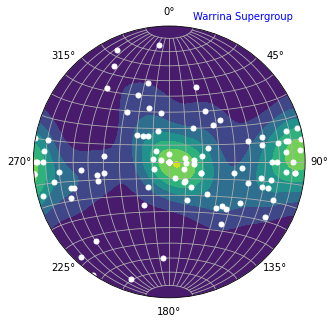

----------------------------------------------------------------------------------------------------------------------
Heysen Supergroup observations n= 218
strike/dip of girdle 124.65644560723149 / 89.70614506898453


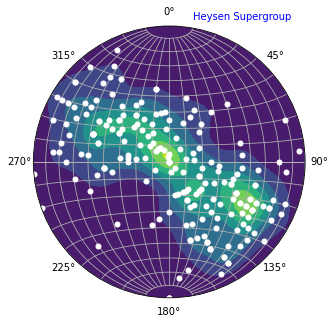

----------------------------------------------------------------------------------------------------------------------
Unnamed GIS Unit - see description observations n= 56
strike/dip of girdle 309.5050902238229 / 86.9949149808441


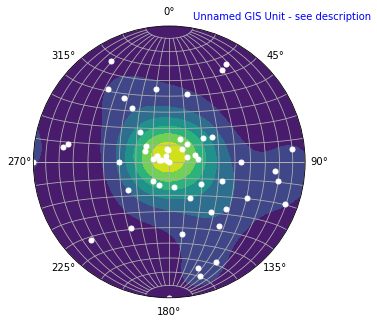

----------------------------------------------------------------------------------------------------------------------
Wilpena Group observations n= 3
strike/dip of girdle 80.7534224822727 / 22.95404573089843


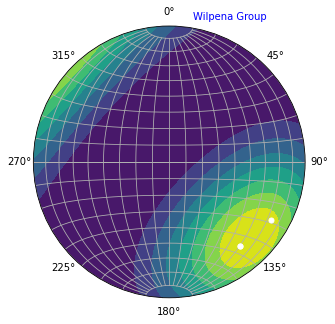

----------------------------------------------------------------------------------------------------------------------
Moralana Supergroup observations has 1 observation
rbf_split 0 18405
['Heysen Supergroup', 'Warrina Supergroup', 'Unnamed GIS Unit - see description', 'Wilpena Group', 'Moralana Supergroup']
172 107
interpolated dips


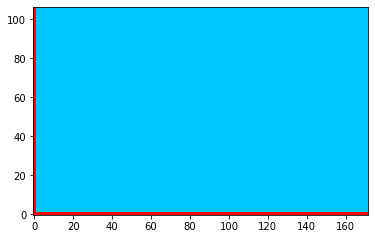

interpolated dip directions


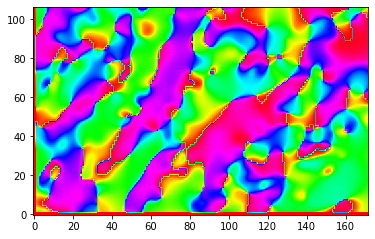

interpolated contacts


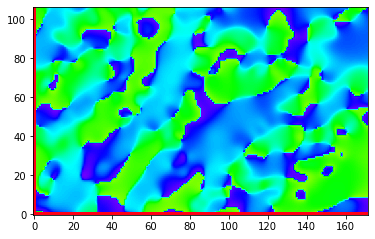

 70%|███████   | 70/100 [00:25<00:17,  1.71it/s]

fault orientations saved as sa-test/output/fault_orientations.csv
fault positions saved as sa-test/output/faults.csv
fault dimensions saved as sa-test/output/fault_dimensions.csv


 90%|█████████ | 90/100 [00:29<00:03,  2.52it/s]

Fault Fault_338 with displacement of 522 capped to 490.7646838061598
fault displacement estimates saved as sa-test/output/fault_displacements3.csv
near-fault orientations saved as sa-test/tmp/ex_f_combo_full.csv
near-fault orientations saved as sa-test/tmp/ex_f_combo_full.csv
0 Wilpena_Group
1 Heysen_Supergroup
2 Warrina_Supergroup
3 Unnamed_GIS_Unit___see_description
pluton contacts and orientations saved as:
sa-test/output/ign_contacts.csv
sa-test/output/ign_orientations_domes.csv
Propagating dips along contacts...
161
551 points saved to sa-test/tmp/raw_contacts.csv
198 thickness estimates saved as sa-test/output/formation_thicknesses.csv
['Yerelina_Subgroup' 'Yudnamutana_Subgroup' 'Emeroo_Subgroup'
 'ABC_Range_Quartzite' 'Wilpena_Group' 'Umberatana_Group'] already processed
62 min thickness estimates appended to sa-test/output/formation_thicknesses.csv
Yerelina_Subgroup 104.0 161.61184533377667
Yudnamutana_Subgroup 178.0 173.28857727114683
Emeroo_Subgroup 167.0 191.3130070504007
AB

100%|██████████| 100/100 [00:45<00:00,  2.21it/s]

cycles []


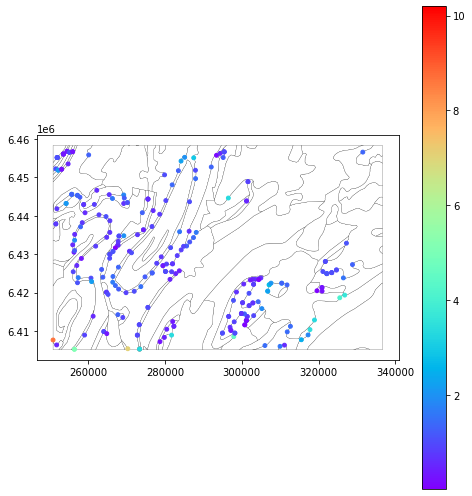

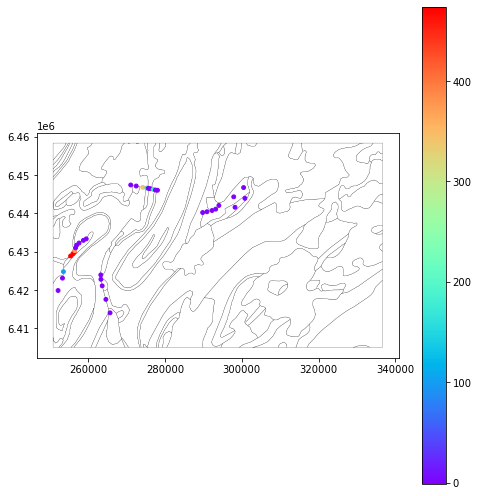

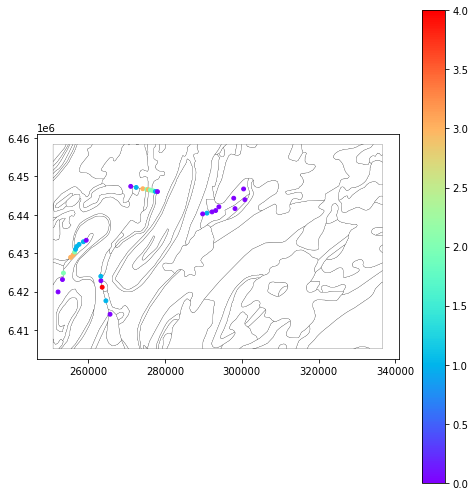

In [7]:
proj.run()

## Loop Structural

In [8]:
# Define project pathing from m2l
proj_path = proj.config.project_path
graph_path = proj.config.graph_path
tmp_path = proj.config.tmp_path
data_path = proj.config.data_path
dtm_path = proj.config.dtm_path
output_path = proj.config.output_path
vtk_path = proj.config.vtk_path

# Define project bounds
minx,miny,maxx,maxy = proj.config.bbox
model_base = proj.config.bbox_3d['base']
model_top = proj.config.bbox_3d['top']

fault_file = proj.config.fault_file_csv

In [9]:
import random
import os
import time
from datetime import datetime
import shutil
import logging
logging.getLogger().setLevel(logging.INFO)

import numpy as np
from LoopStructural import GeologicalModel
import lavavu
from LoopStructural.visualisation import LavaVuModelViewer
from LoopStructural import GeologicalModel

f=open(os.path.join(tmp_path, 'bbox.csv'),'w')
f.write('minx,miny,maxx,maxy,lower,upper\n')
ostr='{},{},{},{},{},{}\n'.format(minx,miny,maxx,maxy,model_base,model_top)
f.write(ostr)
f.close()

fault_params = {'interpolatortype':'FDI',
                'nelements':3e5,
                'fault_buffer':.5,
                'solver':'pyamg',
#                 overprints:overprints,
                'cpw':10,
                'npw':10}
foliation_params = {'interpolatortype':'FDI' , # 'interpolatortype':'PLI', 'FDI', 'surfe'
                    'nelements':3e5,  # how many tetras/voxels
                    'buffer':1.8,  # how much to extend interpolation around box
                    'solver':'pyamg',
                    'damp':True,
                    'cpw':5,
                    'npw':5}

model, m2l_data = GeologicalModel.from_map2loop_directory(proj_path,
                                                          skip_faults=False,
                                                          rescale=False,
                                                          fault_params=fault_params,
                                                          foliation_params=foliation_params)




Updating geological model. There are: 
22 geological features that need to be interpolated



  0%|          | 0/22 [00:00<?, ?it/s]

Model update took: 325.9318025112152 seconds


In [ ]:
view = LavaVuModelViewer(model,vertical_exaggeration=1) 
view.nsteps = np.array([200,200,100])
#view.set_zscale(2)
# view.add_model()
# view.nelements = 3e5#steps=np.array([,50,50])
#view.add_model_surfaces(filename=filename)
view.add_model_surfaces(opacity=0.8)
view.add_data(model['supergroup_0'])
view.interactive()  

  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
# to export the figure to webgl
# view.export_to_webgl('south_australia_model.html')

In [15]:
geol_clip = proj.config.geol_clip
asc=pd.read_csv(tmp_path+'/all_sorts_clean.csv',",")
#display(asc)
colours=pd.read_csv(proj.config.clut_path,",")
if( proj.config.c_l['c']=='CODE'):
    code=proj.config.c_l['c'].lower()
else:
    code=proj.config.c_l['c']

colours = [] #container for the discrete colours we are using
i=0
geol_clip['colour_index'] = np.nan #initialise a colour index attribute column
for ind,strat in asc.iterrows():
    geol_clip[proj.config.c_l['c']].str.replace(" ","_")
    geol_clip.loc[geol_clip[proj.config.c_l['c']]==strat['code'].replace("_"," "),'colour_index'] = i
    colours.append(strat['colour'])
    i=i+1

In [18]:
import matplotlib.pyplot as plt
from LoopStructural.visualisation import MapView
from LoopStructural.visualisation.stratigraphic_column import StratigraphicColumnView
from map2loop.map import MapUtil

Fetching DTM...  bbox:138.2487471414877 139.37108898881752 -32.579487181629595 -31.883661960489242
Attempt: 0 dtm geotif saved as sa-test/dtm/dtm.tif
Done.
reprojected dtm geotif saved as sa-test/dtm/dtm_rp.tif


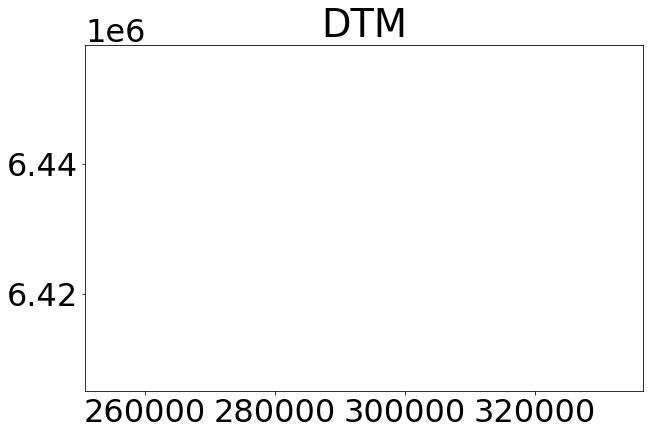

In [23]:
maps =proj.config.geol_clip#geopandas.read_file(proj.config.tmp_path+'geol_clip.shp')
masp = maps[maps['STRATNAM_1']!='Unnamed GIS Unit - see description']

extent=[model.bounding_box[0,0], model.bounding_box[1,0], model.bounding_box[0,1], model.bounding_box[1,1]]


mapview = MapView(model)
proj.config.load_dtm(True)
geomap = MapUtil(proj.config.bbox_3d,maps,proj.config.dtm)
mapview.nsteps = (200,200)
xy = np.array([mapview.xx
               .flatten(),mapview.yy.flatten()]).T
dtm = geomap.evaluate_dtm_at_points(xy)

geo_map = geomap.evaluate_geology_at_points(xy)
# dtm[:]=0
model_map = model.evaluate_model(np.vstack([xy.T,dtm]).T)

In [25]:
data = []
colours = []
boundaries = []
for u, v in m2l_data['stratigraphic_column']['supergroup_0'].items():
    data.append((m2l_data['strat_va'][u],v['colour']))
    colours.append(v['colour'])
    boundaries.append(m2l_data['strat_va'][u])    
from matplotlib import colors
cmap = colors.ListedColormap(colours)
cmap = colors.ListedColormap(cmap.colors[::-1])
b = np.array(boundaries)
print()
b = b[::-1]
boundaries = colors.BoundaryNorm(b,ncolors=len(colours))

# Plot geology map and model comparison

Text(0.5, 1.0, 'C. Interpolated geological map')

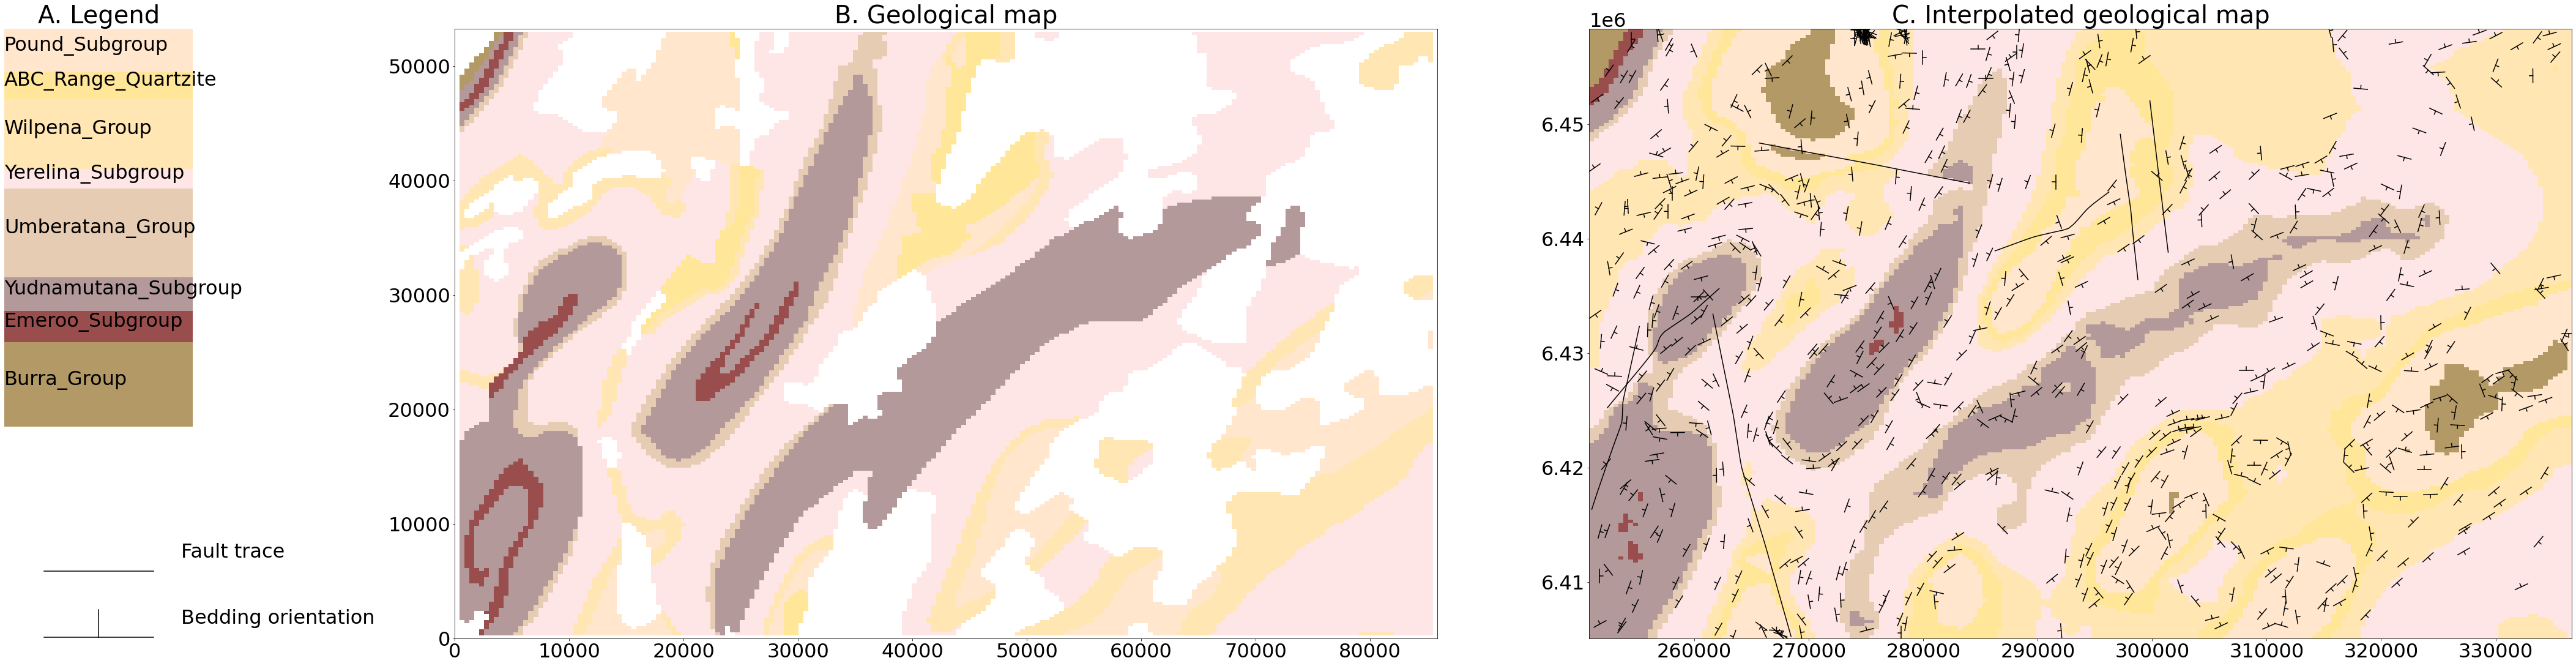

In [26]:
plt.rcParams.update({'font.size': 32})
fig3 = plt.figure(constrained_layout=True,figsize=(60,15))
nx = 6
gs = fig3.add_gridspec(5, 2*nx+1)
legend = fig3.add_subplot(gs[:-1, :1])
strike = fig3.add_subplot(gs[-1:,:1])

#add stike symbol
gradient_data = np.array([[0,1.,0]])
t = gradient_data[:, [1, 0]] * np.array([1, -1]).T
n = gradient_data[:, 0:2]
# t *= symb_scale
n *= 0.5
p1 = gradient_data[:, [0, 1]] - t
p2 = gradient_data[:, [0, 1]] + t
# plt.scatter(val[:,0],val[:,1],c='black')
strike.plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], 'black')
p1 = gradient_data[:, [0, 1]]
p2 = gradient_data[:, [0, 1]] + n
strike.plot([p1[:, 0], p2[:, 0]], [p1[:, 1], p2[:, 1]], 'black')
strike.annotate("Bedding orientation", xy=[0,0],xytext=[1.5,.75],annotation_clip=False,size=32)
strike.set_xlim(-2,2)
# strike.plot()
strike.axis('off')
strike.axis('square')
p1 = gradient_data[:, [0, 1]] - t
p2 = gradient_data[:, [0, 1]] + t
strike.plot([p1[:, 0], p2[:, 0]], [p1[:, 1]+1.2, p2[:, 1]+1.2], 'black')
strike.annotate("Fault trace", xy=[0,1.2],xytext=[1.5,.75+1.2],annotation_clip=False,size=32)

# f3_ax1.set_title('gs[0, :-2]')
geol_map_ax = fig3.add_subplot(gs[:, 1:nx+1])
model_map_ax = fig3.add_subplot(gs[:, nx+1:])

column_ax = StratigraphicColumnView(model,legend)
geol_map_ax.imshow(geo_map.reshape(mapview.nsteps).T,extent=extent,cmap=cmap,origin='lower',vmin=0,vmax=7)
# proj.config.faults_clip.plot(ax=geol_map_ax)
mapview2 = MapView(model,ax=model_map_ax)
mapview2.nsteps=(200,200)
mapview2.add_data(model.features[-1],dip=False,val=False,symb_scale=600)
mapview2.add_model(cmap=cmap,z=dtm)
mapview2.add_faults(colors='black')
model_map_ax.imshow(model_map.reshape(mapview.nsteps).T,extent=extent,cmap=cmap,origin='lower',vmin=0,vmax=7)

legend.set_title('A. Legend',fontsize=40)
geol_map_ax.set_title('B. Geological map',fontsize=40)
model_map_ax.set_title('C. Interpolated geological map',fontsize=40)